In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
df = pd.read_csv('../datasets/final_dataset_cleaned_v1.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id
0,house,independent,sector 25,4.35,32222.0,1350.0,Plot area 150(125.42 sq.m.),5,4,3,servant room,3.0,North,10+ Year Old,"['Vodafone belvedere towers metro station', 'D...",[],"['Feng Shui / Vaastu Compliant', 'Private Gard...",R70162684
1,flat,the close south,sector 50,3.10,12444.0,2491.0,Super Built up area 2491(231.42 sq.m.)Built Up...,3,4,3+,servant room,4.0,North-East,5 to 10 Year Old,"['Fresco Market', 'Emerald Plaza', 'Tagore Pub...","['4 Wardrobe', '8 Fan', '1 Exhaust Fan', '3 Ge...","['Centrally Air Conditioned', 'Water purifier'...",H69433380
2,flat,signature global city 63a,sector 63a,1.65,15263.0,1081.0,Super Built up area 1081(100.43 sq.m.),2,2,2,not available,1.0,NaN,Oct 2024,"['Sector 54 Chowk Metro Station', 'Paras Trini...","['1 Wardrobe', '1 Fan', '1 Light', '1 AC', 'No...",NaN,G69165782
3,flat,saan verdante,sector 95,2.00,10178.0,1965.0,Super Built up area 1965(182.55 sq.m.)Carpet a...,3,4,3+,servant room,5.0,North,0 to 1 Year Old,"['Proposed Metro Station', 'Dwarka Expressway'...",[],"['Feng Shui / Vaastu Compliant', 'Security / F...",U70096330
4,flat,puri diplomatic greens,sector 111,3.90,13000.0,3000.0,Super Built up area 3000(278.71 sq.m.)Carpet a...,4,5,3+,servant room,6.0,North-East,1 to 5 Year Old,"['Dwarka Sector 21 Metro Station', 'Gurgaon Dr...","['1 Water Purifier', '6 Fan', '1 Fridge', '1 E...","['Centrally Air Conditioned', 'Water purifier'...",S69742910


After proper look up col = {additionalRoom, agePossession, furnishDetails}, this cols needs to be handled properly. Need to perform some feature engineering to get some valueable insights from them.

### areaWithType

In [5]:
# areaWithType
df[['area', 'areaWithType']].sample(4)

,area,areaWithType
2286,363.0,Plot area 360(33.45 sq.m.)
1348,2160.0,Plot area 350(292.64 sq.m.)Built Up area: 300 ...
2350,2150.0,Super Built up area 2150(199.74 sq.m.)Carpet a...
2105,1608.0,Super Built up area 1608(149.39 sq.m.)


as we can see areaWithType have multiple types of area and area col isn't reliable because it's not consistent with what area it's showing somecases have built-up area whereas in some cases it has carpet area and so on.

In [6]:
# creating 3 new separate features super built up area, carpet area and builtup area

# extracts super built up area from the text
def extract_super_builtup_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d)', text)
    if match:
        return float(match.group(1))
    return None

In [7]:
# extracts built up area / carpet area from the text
def extract_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [8]:
# some values are in sqft, sq m. So converting all to sqft
def convert_to_sqft(text, area_val):
    if area_val is None: 
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_val), text)
    # if sq m val then convert to sqft
    if match:
        sq_m = float(match.group(1))
        return sq_m*10.7639 # conversion factor
    return area_val

In [9]:
# extracting plot area in independent houses
def extract_plot_area(area):
    match = re.search(r'Plot area (\d+\.?\d*)', area)
    return float(match.group(1)) if match else None

In [10]:
# extract super built up area + convert to sqft
df['super_builtup_area'] = df['areaWithType'].apply(extract_super_builtup_area)
df['super_builtup_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_builtup_area']), axis=1)

In [11]:
# extracts built up area + convert to sqft
df['builtup_area'] = df['areaWithType'].apply(lambda x: extract_area(x, 'Built Up area'))
df['builtup_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['builtup_area']), axis=1)

In [12]:
# extracting carpet area + convert to sqft
df['carpet_area'] = df['areaWithType'].apply(lambda x: extract_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [13]:
df.sample(4)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_builtup_area,builtup_area,carpet_area
1225,flat,ambience creacions,sector 22,3.2,11500.0,2783.0,Super Built up area 2781(258.36 sq.m.),3,4,3+,not available,2.0,North-East,Within 6 months,"['Moulsari Avenue', 'Ambience Mall', 'Old Delh...",NaN,"['Feng Shui / Vaastu Compliant', 'Security / F...",P63118582,2781.0,NaN,NaN
1928,flat,signature global orchard avenue,sector 93,0.4,7359.0,544.0,Carpet area: 543.53 (50.5 sq.m.),2,2,2,not available,11.0,NaN,0 to 1 Year Old,"['JMS Crosswalk Mall', 'Reliance Trends Newtow...","['1 Fan', '1 Exhaust Fan', '1 Geyser', '5 Ligh...","['Security / Fire Alarm', 'Lift(s)', 'Maintena...",X64712920,NaN,NaN,543.57695
1088,flat,vipul world floors,sector 48,4.3,13870.0,3100.0,Carpet area: 3100 (288 sq.m.),4,5,3+,"pooja room,study room,servant room",4.0,East,0 to 1 Year Old,"['Sri Radhe Krishna Temple', 'Icici bank ATM',...",NaN,"['Lift(s)', 'Centrally Air Conditioned', 'High...",L69086224,NaN,NaN,3100.00000
377,house,independent,sector 57,4.7,21759.0,2160.0,Plot area 240(200.67 sq.m.),3,3,2,"servant room,others",2.0,North,10+ Year Old,"['Radhakrishna Shani Mandir', 'Sanatan Dharm M...",[],"['Feng Shui / Vaastu Compliant', 'Private Gard...",J69745426,NaN,NaN,NaN


In [14]:
# getting the count of rows with all 3 areas present
df[~((df['super_builtup_area'].isnull()) | (df['builtup_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_builtup_area','builtup_area','carpet_area']].shape


(534, 7)

In [15]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_builtup_area','builtup_area','carpet_area']].shape


(682, 7)

count is very less so in future i need to handle missing values. Because it's very important 

but the independent houses data contained plot area in areaWithType (around 690 rows). which is huge

In [16]:
df.isnull().sum()

property_type            0
society                  1
sector                   0
price                   18
price_per_sqft          18
area                    18
areaWithType             0
bedRoom                  0
bathroom                 0
balcony                  0
additionalRoom           0
floorNum                19
facing                1105
agePossession            1
nearbyLocations        177
furnishDetails         981
features               635
property_id              0
super_builtup_area    1888
builtup_area          2616
carpet_area           1859
dtype: int64

In [17]:
# finding the rows with all 3 areas missing
all_nan_df = df[((df['super_builtup_area'].isnull()) & (df['builtup_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_builtup_area','builtup_area','carpet_area']]


In [18]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_builtup_area,builtup_area,carpet_area
0,4.35,house,1350.0,Plot area 150(125.42 sq.m.),NaN,NaN,NaN
24,8.40,house,4000.0,Plot area 4000(371.61 sq.m.),NaN,NaN,NaN
35,5.60,house,4000.0,Plot area 4000(371.61 sq.m.),NaN,NaN,NaN
39,11.75,house,2844.0,Plot area 316(264.22 sq.m.),NaN,NaN,NaN
41,9.54,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN


In [19]:
# storing their indices, might be useful later
all_nan_indices = df[((df['super_builtup_area'].isnull()) & (df['builtup_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_builtup_area','builtup_area','carpet_area']].index

In [20]:
all_nan_df['builtup_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

In [21]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_builtup_area,builtup_area,carpet_area
0,4.35,house,1350.0,Plot area 150(125.42 sq.m.),NaN,150.0,NaN
24,8.40,house,4000.0,Plot area 4000(371.61 sq.m.),NaN,4000.0,NaN
35,5.60,house,4000.0,Plot area 4000(371.61 sq.m.),NaN,4000.0,NaN
39,11.75,house,2844.0,Plot area 316(264.22 sq.m.),NaN,316.0,NaN
41,9.54,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.0,NaN


In [22]:
# plot area values are in sq. yards need to convert to sqft
def conversion_scaler(row):
    if np.isnan(row['area']) or np.isnan(row['builtup_area']):
        return row['builtup_area']
    else: 
        if round(row['area']/row['builtup_area']) == 9.0:  # value is in sq. yards
            return row['builtup_area'] * 9
        elif round(row['area']/row['builtup_area']) == 11.0: # value is in sq. m.
            return row['builtup_area'] * 10.7639
        else: # value is in sqft itself
            return row['builtup_area']

In [23]:
all_nan_df['builtup_area'] = all_nan_df.apply(conversion_scaler, axis=1)

In [24]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_builtup_area,builtup_area,carpet_area
0,4.35,house,1350.0,Plot area 150(125.42 sq.m.),NaN,1350.0,NaN
24,8.40,house,4000.0,Plot area 4000(371.61 sq.m.),NaN,4000.0,NaN
35,5.60,house,4000.0,Plot area 4000(371.61 sq.m.),NaN,4000.0,NaN
39,11.75,house,2844.0,Plot area 316(264.22 sq.m.),NaN,2844.0,NaN
41,9.54,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.0,NaN


In [25]:
# updating changes to df
df.update(all_nan_df)

In [26]:
df.isnull().sum()

property_type            0
society                  1
sector                   0
price                   18
price_per_sqft          18
area                    18
areaWithType             0
bedRoom                  0
bathroom                 0
balcony                  0
additionalRoom           0
floorNum                19
facing                1105
agePossession            1
nearbyLocations        177
furnishDetails         981
features               635
property_id              0
super_builtup_area    1888
builtup_area          2070
carpet_area           1859
dtype: int64

Still many missing values present, need to handle

### additionalRoom

In [27]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
study room,servant room                            99
store room                                         99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
servant room,

types of additional rooms = {servant room, pooja room, others, store room, study room} making 5 features for each additional room (kind of OHE)

In [28]:
new_cols = ['study room', 'pooja room', 'store room', 'servant room', 'others']

for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [29]:
df.sample(4)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_builtup_area,builtup_area,carpet_area,study room,pooja room,store room,servant room,others
1704,house,independent,sector 17,9.50,23457.0,4050.0,Plot area 502(419.74 sq.m.)Built Up area: 500 ...,8,8,3,study room,3.0,West,1 to 5 Year Old,"['Iffco chowk metro station', 'Citi bank ATM',...","['8 Wardrobe', '12 Fan', '1 Exhaust Fan', '8 G...","['Maintenance Staff', 'Water Storage', 'Visito...",P69309028,NaN,500.0,450.0,1,0,0,0,0
3041,house,unitech espace,sector 50,NaN,NaN,NaN,Plot area 360(301.01 sq.m.),5,5,3+,study room,2.0,NaN,5 to 10 Year Old,"['Radhakrishna Shani Mandir', 'Sri Radhe Krish...","['5 Wardrobe', '5 Fan', '11 Light', '6 AC', 'N...","['Maintenance Staff', 'Water Storage', 'Park',...",W69179004,NaN,360.0,NaN,1,0,0,0,0
3625,flat,unitech harmony,sector 50,2.60,9590.0,2711.0,Super Built up area 2711(251.86 sq.m.)Built Up...,3,4,2,"servant room,others",15.0,North-East,1 to 5 Year Old,"['Huda Metro Station (Gurugram)', 'M3M Cosmopo...","['3 Wardrobe', '7 Fan', '1 Exhaust Fan', '4 Ge...","['Centrally Air Conditioned', 'Water purifier'...",Y69284872,2711.0,2700.0,2200.0,0,0,0,1,1
552,flat,capital residences 360,sector 70a,1.64,8299.0,1976.0,Super Built up area 1976(183.58 sq.m.)Built Up...,3,3,3+,servant room,4.0,North-East,0 to 1 Year Old,NaN,"['4 AC', '1 Chimney', 'No Bed', 'No Curtains',...","['Centrally Air Conditioned', 'Water purifier'...",Q70068034,1976.0,1950.0,1642.0,0,0,0,1,0


### agePossession

In [30]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Jan 2024                 8
Oct 2024                 8
Jun 2024                 7
Dec 2025                 7
Aug 2023                 7
Nov 2023                 5
Jul 2024                 4
By 2025                  4
Oct 2023                 4
Aug 2024                 4
Sep 2023                 4
May 2024                 3
Nov 2024                 3
Feb 2024                 3
Jan 2025                 3
Jun 2027                 2
Jul 2027                 2
Apr 2026                 2
Oct 2025                 2
Mar 2025                 2
Dec 2026                 2
Jul 2025                 2
Jan 2026                 2
By 2027       

In [31]:
# deviding possession into 5 categories
def age_possession_handler(value):
    if pd.isna(value):
        return "Undefined"
    if '0 to 1 Year Old' in value or "Within 6 monnts" in value or "Within 3 months" in value:
        return "New Property"
    if '1 to 5 Years Old' in value:
        return "Relatively New"
    if '5 to 10 Years Old' in value:
        return "Moderately Old"
    if '10+ Years Old' in value:
        return "Old Property"
    if 'Under Construction' in value or 'By' in value:
        return "Under Construction"
    try:
        # to handle "Nov 2023" like values
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [32]:
df['agePossession'] = df['agePossession'].apply(age_possession_handler)

### furnishDetails

quite hard to handle becuase of much information present in the form of strings

In [33]:
df.sample(4)[['furnishDetails', 'features']]

,furnishDetails,features
1501,"['4 Geyser', '5 Light', '1 Chimney', 'No AC', ...","['Security / Fire Alarm', 'Feng Shui / Vaastu ..."
2224,NaN,"['Security / Fire Alarm', 'Power Back-up', 'Fe..."
1404,[],NaN
175,"['1 Water Purifier', '5 Fan', '1 Fridge', '1 D...","['Lift(s)', 'Maintenance Staff', 'Park', 'Visi..."


In [34]:
# extracting all unique furnishing items
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))
    

In [35]:
# function to get the counts of furnishing items
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

In [36]:
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings


In [37]:
# new cols for each new furnishing item
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]

In [38]:
df.sample(4)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_builtup_area,builtup_area,carpet_area,study room,pooja room,store room,servant room,others,Stove,Exhaust Fan,Washing Machine,TV,Curtains,Light,Water Purifier,Chimney,Sofa,Dining Table,Fridge,AC,Microwave,Fan,Modular Kitchen,Wardrobe,Geyser,Bed
829,flat,mvn athens,sohna road,0.25,5198.0,481.0,Built Up area: 481 (44.69 sq.m.),2,2,0,not available,0.0,NaN,Undefined,"['SBI ATM', 'Axis bank ATM', 'UCO bank ATM', '...","['3 Fan', '5 Light', '1 Modular Kitchen', 'No ...","['Security / Fire Alarm', 'Lift(s)', 'Maintena...",G69536248,NaN,481.0,NaN,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,3,1,0,0,0
2464,house,bptp visionnaire,sector 70a,6.00,22222.0,2700.0,Plot area 300(250.84 sq.m.),5,4,3,study room,3.0,North-East,New Property,"['Good Earth City Center 2', 'Kunskapsskolan I...","['1 Fan', '1 Geyser', '1 Light', '1 Chimney', ...","['Feng Shui / Vaastu Compliant', 'Maintenance ...",I69662056,NaN,2700.0,NaN,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0
3236,flat,m3m soulitude,sector 89,1.00,9066.0,1103.0,Carpet area: 1103 (102.47 sq.m.),2,2,2,study room,2.0,NaN,Undefined,"['Vatika Town Square-INXT', 'Sector 86 Road', ...",NaN,"['Feng Shui / Vaastu Compliant', 'Security / F...",P69680328,NaN,NaN,1103.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
611,flat,landmark the residency,sector 103,0.90,6666.0,1350.0,Super Built up area 1350(125.42 sq.m.),2,2,2,not available,1.0,South-West,Undefined,"['State bank ATM', 'Dr. Hitesh Dawar', 'Bhardw...","['1 Modular Kitchen', 'No AC', 'No Bed', 'No C...","['Security / Fire Alarm', 'Intercom Facility',...",B58881018,1350.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [39]:
furnishings_df.shape

(3803, 19)

In [40]:
furnishings_df.drop(columns=['furnishDetails'], inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_23188\466072287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'], inplace=True)


I want to categories it into 3 groups : fully furnished, semi furnished, unfurnished. Applying clustering to find the logic

In [47]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [48]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [49]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

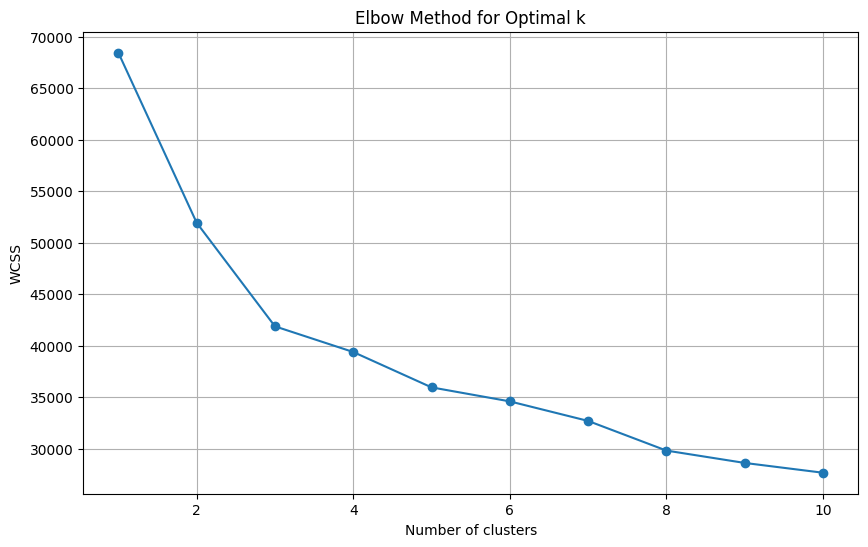

In [50]:
# elbow curve to get the optimal number of clusters 
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

It's great news that c = 3 is optimal value because we needed the same.

In [51]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

KMeans(n_clusters=3, random_state=42)

In [52]:
cluster_assignments = kmeans.predict(scaled_data)

In [54]:
df = df.iloc[:, :-18]

In [55]:
df['furnishing_type'] = cluster_assignments

In [56]:
df.sample(4)[['furnishDetails', 'furnishing_type']]

,furnishDetails,furnishing_type
1513,"['1 Water Purifier', '1 Fridge', '1 Fan', '1 G...",1
2948,"['5 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stov...",2
2913,NaN,0
2657,"['3 Wardrobe', '8 Fan', '1 Exhaust Fan', '2 Ge...",2


0 --> unfurnished  
1 --> semi-furnished  
2 --> fully-furnished

### featues

In [57]:
df[['features']].sample(4)

,features
1077,"['Water purifier', 'Security / Fire Alarm', 'P..."
1447,"['Feng Shui / Vaastu Compliant', 'Security / F..."
1818,"['Centrally Air Conditioned', 'Water purifier'..."
1887,"['High Ceiling Height', 'Water Storage', 'Park..."


In [58]:
df['features'].isnull().sum()

np.int64(635)

many missing values are present. so i have dataset in which same data is present with less missing values so i'm going to replace it.

In [59]:
app_df = pd.read_csv('../datasets/appartments.csv')
app_df.head(4)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."
2,Adani Brahma Samsara Vilasa,"Land, 3, 4 BHK Independent Floor in Sector 63,...","['AIPL Business Club Sector 62', 'Heritage Xpe...","{'AIPL Business Club Sector 62': '2.7 Km', 'He...",https://www.99acres.com/adani-brahma-samsara-v...,{'3 BHK': {'building_type': 'Independent Floor...,"['Terrace Garden', 'Gazebo', 'Fountain', 'Amph..."
3,Sobha City,"2, 3, 4 BHK Apartment in Sector 108, Gurgaon","['The Shikshiyan School', 'WTC Plaza', 'Luxus ...","{'The Shikshiyan School': '2.9 KM', 'WTC Plaza...",https://www.99acres.com/sobha-city-sector-108-...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Volley Ball Court', 'Aerobi..."


In [60]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [61]:
temp_df = df[df['features'].isnull()]

In [62]:
temp_df.shape

(635, 27)

In [ ]:
x = temp_df.merge(app_df, left_on='society', right_on='PropertyName', how='left')['TopFacilities'] # merging data

In [64]:
df.loc[temp_df.index, 'features'] = x.values

In [65]:
df['features'].isnull().sum()

np.int64(481)

missing values count reduced

now there are about 130 unique parameters present we are going to create 130-dim vectors and perform clustering on it. get the optimal cluster count and then categories them 

In [66]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [67]:
# convert string to list of features
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

In [69]:
# using MultiLabelBinarizer to create binary matrix
mlb = MultiLabelBinarizer()
features_matrix = mlb.fit_transform(df['features_list'])

In [70]:
# convert binary matrix to DataFrame
features_binary_df = pd.DataFrame(features_matrix, columns=mlb.classes_)

In [72]:
features_binary_df.shape

(3803, 130)

In [74]:
# performing KMeans again
wcss = []

for i in range(1, 13):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss.append(kmeans.inertia_)

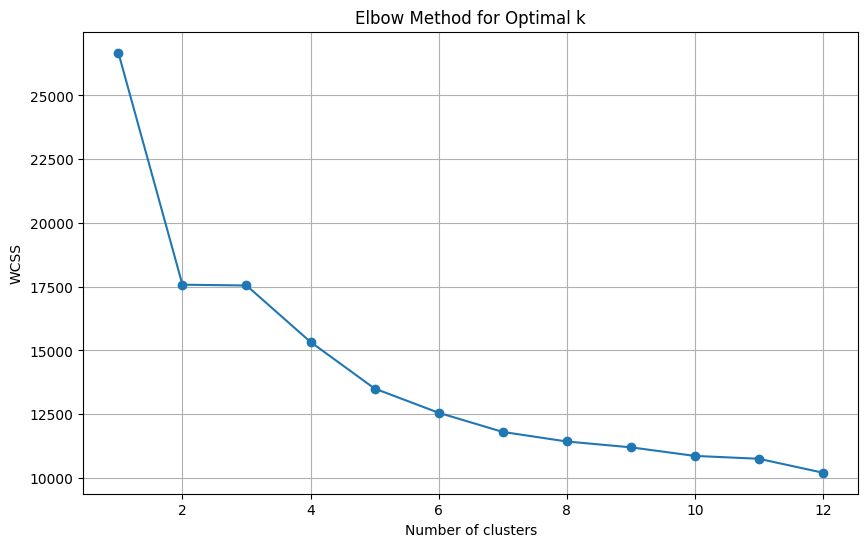

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 13), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

can't get into 3 categories, we failed.

trying to give a score to features like: facility_score, since categorical values didn't work let's tryout numerical values. gave weights to each facility

In [77]:
# ai generated weights for each feature
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}

In [78]:
facility_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [79]:
df['facility_score'] = facility_score

In [80]:
df.sample(4)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_builtup_area,builtup_area,carpet_area,study room,pooja room,store room,servant room,others,furnishing_type,features_list,facility_score
3166,house,independent,sector 26,19.00,42222.0,4500.0,Plot area 500(418.06 sq.m.),6,8,3+,"pooja room,study room,servant room,store room",3.0,East,Undefined,"['Guru dronacharya metro station', 'Dlf phase ...","['11 Fan', '1 Exhaust Fan', '55 Light', '9 AC'...","['Feng Shui / Vaastu Compliant', 'Private Gard...",M70013508,NaN,4500.0,NaN,1,1,1,1,0,2,"[Feng Shui / Vaastu Compliant, Private Garden ...",103
516,flat,aipl zen residences,sector 70a,1.25,9904.0,1262.0,Carpet area: 1262 (117.24 sq.m.),2,2,3,not available,19.0,NaN,Undefined,"['Sri Radhe Krishna Temple', 'Sai Dharamraj Ho...","['1 Light', 'No AC', 'No Bed', 'No Chimney', '...",NaN,U68368438,NaN,NaN,1262.0,0,0,0,0,0,0,[],0
1755,flat,dlf the arbour,sector 63,7.90,20000.0,3950.0,Built Up area: 3950 (366.97 sq.m.)Carpet area:...,4,4,3+,not available,34.0,NaN,Under Construction,"['Radhakrishna Shani Mandir', 'pracksht hospit...",[],"['Swimming Pool', 'Community Hall', 'Yoga/Medi...",A69395700,NaN,3950.0,2900.0,0,0,0,0,0,0,"[Swimming Pool, Community Hall, Yoga/Meditatio...",61
1134,flat,godrej nature plus,sector 33,1.25,9025.0,1385.0,Carpet area: 1385 (128.67 sq.m.),2,2,3+,not available,15.0,NaN,Under Construction,"['Signature Global Infinity Mall Sohna', 'Bads...",[],"['Security / Fire Alarm', 'Intercom Facility',...",H66348120,NaN,NaN,1385.0,0,0,0,0,0,0,"[Security / Fire Alarm, Intercom Facility, Lif...",44


In [81]:
# droping irrelevant columns
df.drop(columns=['nearbyLocations', 'features', 'features_list', 'furnishDetails', 'additionalRoom'], inplace=True)

In [82]:
df.sample(4)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,property_id,super_builtup_area,builtup_area,carpet_area,study room,pooja room,store room,servant room,others,furnishing_type,facility_score
2428,house,independent,sector 7,1.20,11194.0,1072.0,Built Up area: 1072 (99.59 sq.m.),5,4,2,3.0,NaN,Undefined,A67904096,NaN,1072.0,NaN,0,0,0,0,0,0,0
1460,flat,ss almeria,sector 84,1.50,7500.0,2000.0,Super Built up area 2000(185.81 sq.m.)Carpet a...,3,3,3,2.0,NaN,New Property,G24821069,2000.0,NaN,1700.0,0,0,0,1,0,0,108
873,flat,imperia the esfera,sector 37c,0.98,5399.0,1815.0,Super Built up area 1815(168.62 sq.m.)Carpet a...,3,4,3,9.0,South-West,Undefined,T70039480,1815.0,NaN,1510.0,0,0,0,1,1,0,49
3264,flat,tulip monsella,sector 53,8.25,28000.0,2946.0,Super Built up area 2940(273.13 sq.m.),3,4,3,8.0,NaN,Under Construction,F68216448,2940.0,NaN,NaN,0,0,0,1,0,1,35


In [83]:
df.shape

(3803, 24)

In [84]:
df.to_csv('../datasets/final_dataset_feature_engineered_v2.csv', index=False)